# Are popular teachers getting paid more?
### By Sean Huang and Tochukwu Ibe-Ekeocha


## Introduction

What makes a good teacher? Depending on who you ask, you might get different answers to this question. For many people, teacher is only as good 

In [1]:
import requests as req
import pandas as pd
import sqlite3 as sql
import requests
from functools import reduce
import numpy as np
import os.path
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
sqlite_file = 'salaries_data.sql'

In [3]:
db = sql.connect(":memory:")

In [4]:
sql_file = open(sqlite_file)
sql_as_string = sql_file. read()
db. executescript(sql_as_string)

## Data  Collection

To start, we first need some data on both the salaries of each professors in the university as well as their popularity. Since popularity is somewhat abstract and subjective, we decided to use the review that they recieved from their past students. For the salary data, we found a website called the Diamondback Salary Guide(https://salaryguide.dbknews.com/), a platform that allows the user to look up any university staff and get their salary, department, and position. Since they do not have an API and they chose to not disclose their database, we had to scrape these data directly from their website. They did not have a way to scrape the data from each page via URL, we had to use a chrome plugin called//TODO. For the review data, we used the API of PlanetTerp, the official review site for UMD professors.

In [5]:
salary_query= """
SELECT 
 firstname, lastname, department, salary, position
FROM Salaries
"""

In [6]:
salaries = pd.read_sql(salary_query, db)

In [7]:
salaries.head()

,firstname,lastname,department,salary,position
0,DJ,Durkin,PRES,881010.96,Head Coach
1,Darryll J,Pines,PRES,765000.00,President
2,Wallace,Loh,PRES,734565.88,Spec Asst to the Pres
3,Mark,Turgeon,PRES,723312.99,Head Coach
4,Brenda S,Frese,PRES,659386.43,Head Coach BB


In [8]:
def count_nonempty(d): 
    total = 0
    for k in d.keys():
        if (d.get(k) != None):
            total += 1
    print("the non empty total", total)

In [9]:
headers = {
  'Accept': 'application/json'
}

In [10]:
def fetch_profs(): 
    profs = dict()
    matched_profs = dict()

    for i in range(0, 10000, 1000):
        r = requests.get('https://api.planetterp.com/v1/professors?reviews=true', params={
          'limit': '1000',
          'offset': i,
        }, headers = headers)

        for e in r.json():
            profs[e.get("slug")] = e
            matched_profs[e.get("slug")] = None
    return (profs, matched_profs)

Since the process of pulling every single professor from PlanetTerp takes a long time, we decided to check if there is a local database we can use before calling the API, and just using the local data if one is found. If one is not found, we fetch the professors 1000 at a time, using the API. After we fetch them, we save it locally so we don't have to do wait next time.

In [14]:
def fetch_matched_salaries():
    if(path.isfile("matched_salaries.csv")):
        return pd.read_csv("matched_salaries.csv")
    
    
    (profs, matched_profs) = fetch_profs()
    
    arr = list(set(salaries["department"]))
    for dep in arr:   
        get_department(dep, profs, matched_profs)
        
    data = [ list(v)  for v in matched_profs.values() if v != None]
    matched_salaries = pd.DataFrame(data, columns=['firstname', 'lastname', 'department', 'salary', "position", "avg_rating", 'slug', "planetTerpName", "courses", "num_courses"])
    matched_salaries.to_csv(path_or_buf="matched_salaries.csv", index=False)
    return matched_salaries


## Data management

We now have two data sets with information on UMD's profesors. Since they came from two different places and uses different format, we will have to merge them manually. To do this, we wrote a function called find_closest_match(), which find the closest match for a name in a dataframe.

In [11]:
def find_closest_match(name, matches):
    firstname = name.split(" ")[0]
    ret = [ m  for m in matches if m[0].find(firstname) >= 0 ]
    if(len(ret) > 0):
        return ret[0]
    return None
def calc_avg_review(revs):
    length = len(revs)
    if(length == 0):
        return np.nan
    total = 0
    for r in revs:
        total += r.get("rating")
    return total / length
        

With a simple helper method, we are also able to parse each professor's information into columns in a dataframe.

In [12]:
def get_department(dep, profs, matched_profs):
    matches = dict()

    for prof in profs.values():
        
        slug = prof.get("slug")
        name = prof.get("name")
        courses = prof.get("courses")
        avg_rating = calc_avg_review(prof.get("reviews"))
        
        if(matched_profs.get(slug) != None):
            continue

        lastname = name.split(" ")[-1]

        salary_query= f"""
            SELECT 
            firstname, 
            lastname,
            department,
            salary,
            position
            FROM Salaries
            WHERE lastname like "{lastname}"
            AND department = "{dep}"
        """
        rows = list(db.execute(salary_query))
        matches[lastname] = (len(rows), rows, name, slug, courses, avg_rating)
        

    for match in matches.keys():
        (length, v, name, slug, courses, avg_rating) = matches.get(match)
        if(length > 0):
           
            value = find_closest_match(name, v)
         
            if(value != None):
                
                matched_profs[slug] = (
                    value[0],
                    value[1],
                    value[2],
                    value[3],
                    value[4],
                    avg_rating,
                    slug,
                    name,
                    "-".join(courses),
                    len(courses)
                )
                

    return

In [13]:
data = []

Since we are only looking into professors, we filter the database to only inclue those with either "Lectuerer" or "Professor" in their position. 

In [77]:
matched_salaries = fetch_matched_salaries()
matched_salaries = matched_salaries[matched_salaries['position'].str.contains("Professor") | matched_salaries['position'].str.contains("Lecturer")]
matched_salaries.head()

,firstname,lastname,department,salary,position,avg_rating,slug,planetTerpName,courses,num_courses
0,A W,Kruglanski,BSOS,322501.74,Distinguished Univ Professor,2.0,kruglanski,A Kruglanski,PSYC743-PSYC748M-PSYC489H-PSYC489T-PSYC789-PSY...,9
1,Aaron,Finkle,BSOS,75054.05,Lecturer,3.5,finkle,Aaron Finkle,ECON306-ECON641-ECON321-ECON456-ECON488K-BUSO604,6
2,Aaron Gilad,Kusne,ENGR,17945.31,Lecturer,NaN,kusne,Aaron Kusne,ENMA489L,1
3,Aaron Wolf,Mannes,PLCY,15300.00,Lecturer,NaN,mannes,Aaron Mannes,PLCY780,1
4,Aaron George,Swanlek,ARHU,37087.20,Lecturer,5.0,swanlek,Aaron Swanlek,COMM107,1


//TODO: explain this or unfuck it.

In [16]:
def fetch_reviewsData(_data, ids):
    if(path.isfile("reviews.csv")):
        return pd.read_csv("reviews.csv")
        
    reviews_data = []
    i = 0
    for v in _data:

        r = requests.get('https://api.planetterp.com/v1/professor', params={
          'name': v,  'reviews': 'true'
        }, headers = headers).json()


        slug = r.get("slug")
        revs = r.get("reviews")
        if(revs == None):
            continue

        for rev in revs:  

            reviews_data.append([ 
                slug,
                rev.get("rating"),  
                rev.get("expected_grade"), 
                rev.get("course"),
                rev.get("review"),
                ids[i]
            ])
            
        i += 1;
    reviews_df = pd.DataFrame(reviews_data, columns=['slug', 'rating', 'expected_grade', 'course', 'review', "prof_df_id"])
    reviews_df.to_csv(path_or_buf="reviews.csv", index=False)
    return  reviews_df



In [17]:
reviews_df = fetch_reviewsData(list(matched_salaries["planetTerpName"]), matched_salaries.index.values)
reviews_df.head()

,slug,rating,expected_grade,course,review,prof_df_id
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",0
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4


## Exploratory data analysis

In [18]:
dept_avg = matched_salaries.groupby("department").mean().sort_values(by=["salary"], ascending=False)
dept_avg
dept_avg = dept_avg.dropna()

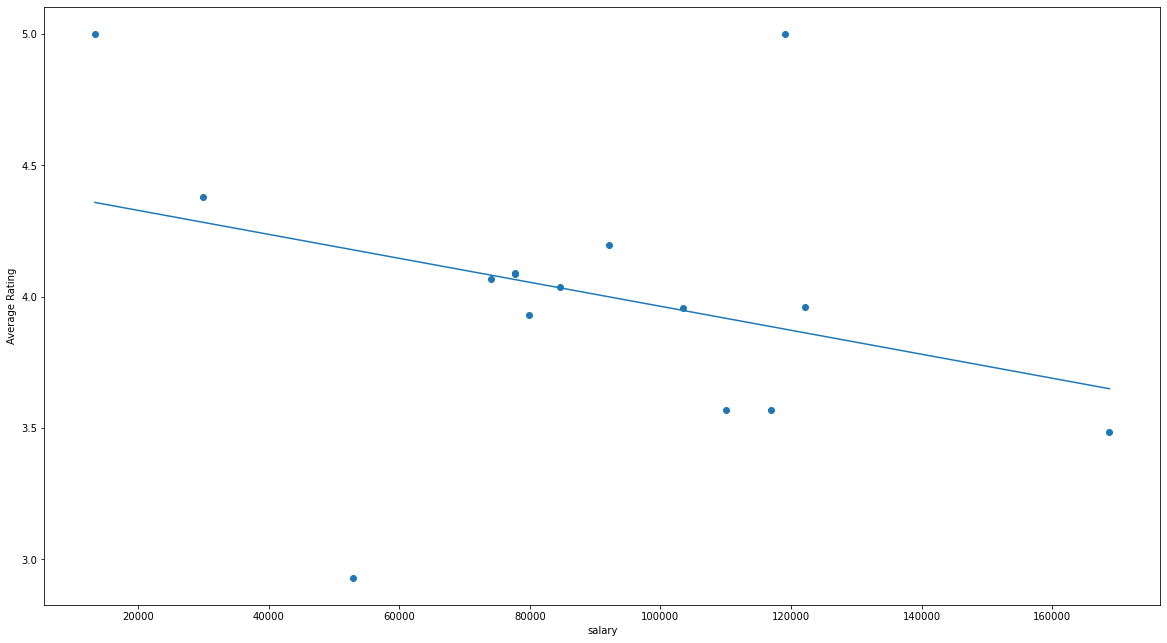

In [19]:
figsize = (20, 11)
plt.figure(figsize=figsize)
plt.scatter(dept_avg['salary'], dept_avg['avg_rating'])
plt.xlabel('salary')
plt.ylabel('Average Rating')

m,b = np.polyfit(dept_avg['salary'], dept_avg['avg_rating'], 1)


plt.plot(dept_avg['salary'], m * dept_avg['salary'] + b)

plt.show()

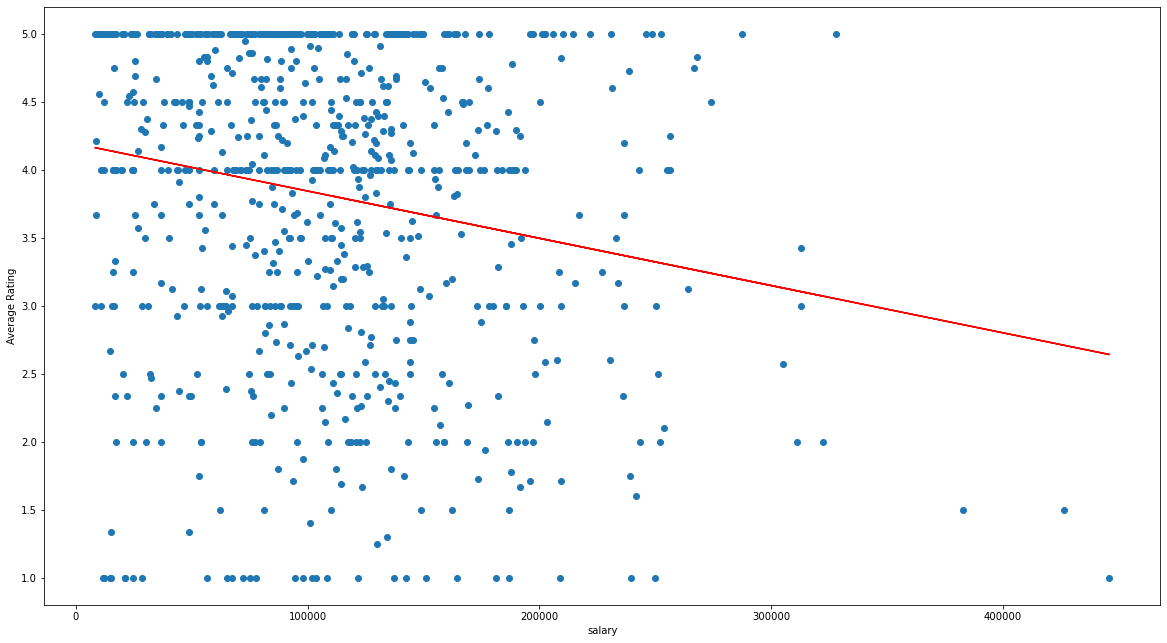

In [20]:
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])

prof_salary = prof_salary[prof_salary['position'].str.contains("Professor") | prof_salary['position'].str.contains("Lecturer")]

plt.figure(figsize=figsize)
plt.scatter(prof_salary['salary'], prof_salary['avg_rating'])
plt.xlabel('salary')
plt.ylabel('Average Rating')

m,b = np.polyfit(prof_salary['salary'], prof_salary['avg_rating'], 1)
plt.plot(prof_salary['salary'], m * prof_salary['salary'] + b, color = 'red')
plt.show()

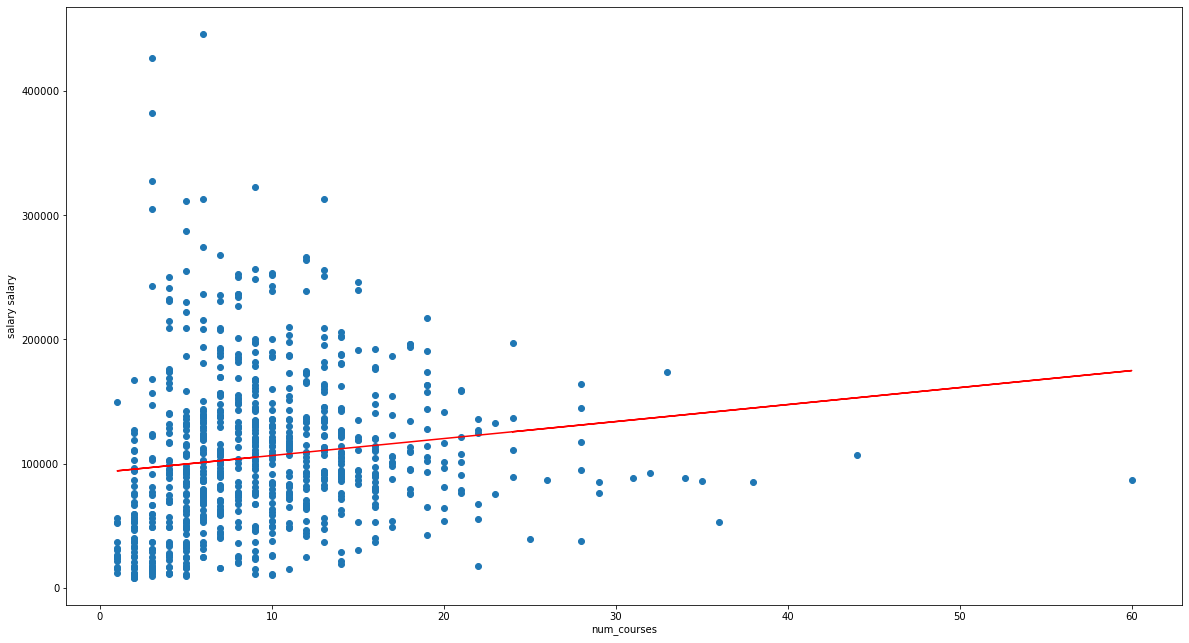

In [21]:
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])
plt.figure(figsize=figsize)

plt.scatter(prof_salary['num_courses'], prof_salary['salary'])
plt.xlabel('num_courses')
plt.ylabel('salary salary')

m,b = np.polyfit(prof_salary['num_courses'], prof_salary['salary'], 1)
plt.plot(prof_salary['num_courses'], m * prof_salary['num_courses'] + b, color = 'red')
plt.show()

[Text(0, 0.5, 'salary'),
 Text(0, 1.5, 'avg_rating'),
 Text(0, 2.5, 'num_courses')]

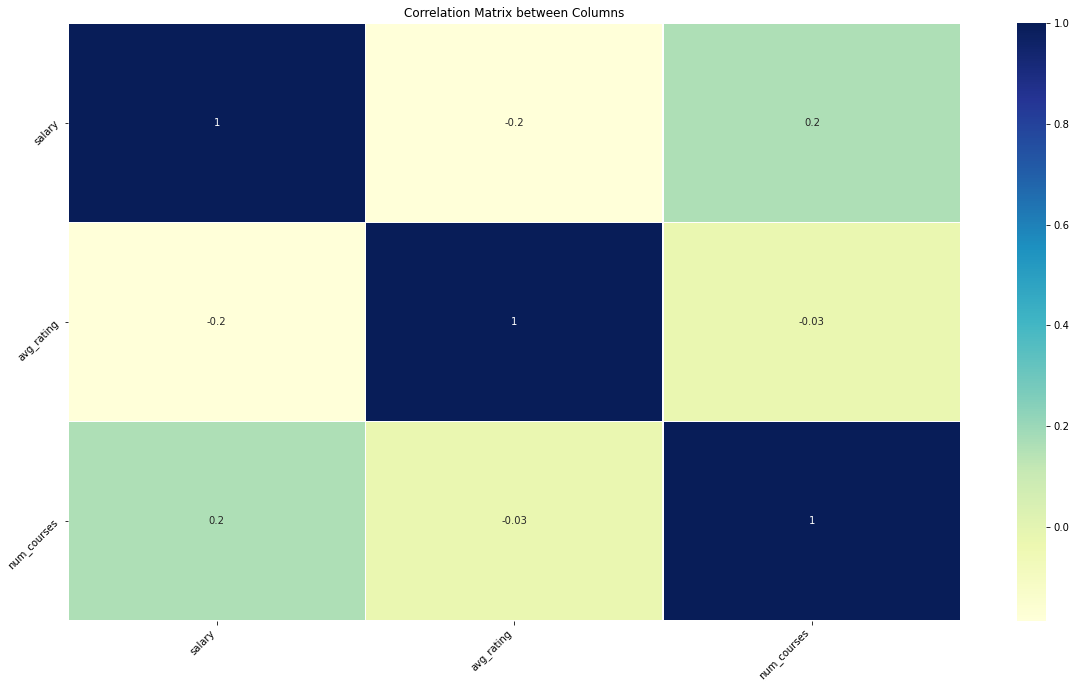

In [22]:
plt.subplots(figsize = figsize)
g = sns.heatmap(matched_salaries.corr(), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

In [23]:
dept_features = pd.get_dummies(matched_salaries['department'], drop_first = True, prefix = 'dept')
std_features = matched_salaries[['avg_rating', 'salary', 'num_courses']]

#combine our data
comb_features = pd.concat([std_features, dept_features], axis = 1)

[Text(0, 0.5, 'avg_rating'),
 Text(0, 1.5, 'salary'),
 Text(0, 2.5, 'num_courses'),
 Text(0, 3.5, 'dept_ARCH'),
 Text(0, 4.5, 'dept_ARHU'),
 Text(0, 5.5, 'dept_BMGT'),
 Text(0, 6.5, 'dept_BSOS'),
 Text(0, 7.5, 'dept_CMNS'),
 Text(0, 8.5, 'dept_EDUC'),
 Text(0, 9.5, 'dept_ENGR'),
 Text(0, 10.5, 'dept_EXST'),
 Text(0, 11.5, 'dept_INFO'),
 Text(0, 12.5, 'dept_JOUR'),
 Text(0, 13.5, 'dept_PLCY'),
 Text(0, 14.5, 'dept_SPHL'),
 Text(0, 15.5, 'dept_SVPAAP'),
 Text(0, 16.5, 'dept_UGST'),
 Text(0, 17.5, 'dept_VPR')]

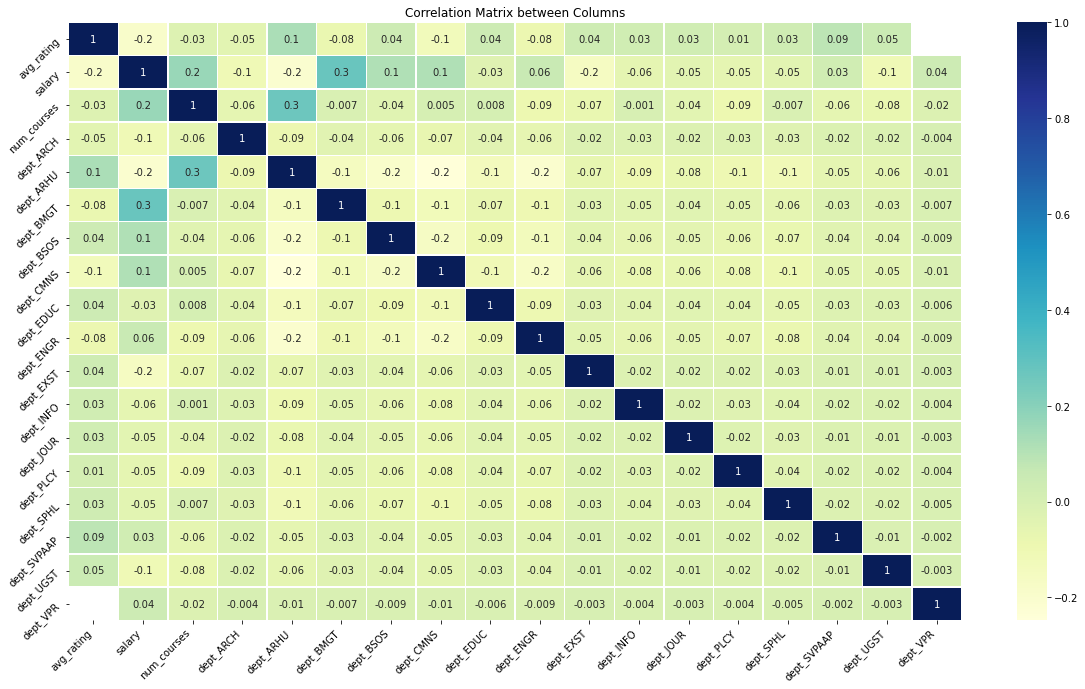

In [24]:
plt.subplots(figsize = figsize)
g = sns.heatmap(comb_features.corr(), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

## Hypothesis Testing/Machine Learning

### Hypothesis 1

Knowing the number of courses, average rating, and department for each of the professors, we can predict what the salary should be.

In [25]:
dept_features = pd.get_dummies(matched_salaries['department'], drop_first = True, prefix = 'dept')
std_features = matched_salaries[['num_courses', 'avg_rating', 'salary']]

comb_features = pd.concat([std_features, dept_features], axis = 1)

comb_features = comb_features.dropna()
for i in filter(lambda i : i!= 'AGNR', matched_salaries['department'].unique()):
    comb_features['num_course*' + i] = comb_features['dept_' + i]*comb_features['num_courses']
    comb_features['rating*' + i] = comb_features['dept_' + i]*comb_features['avg_rating']
    
comb_features

,num_courses,avg_rating,salary,dept_ARCH,dept_ARHU,dept_BMGT,dept_BSOS,dept_CMNS,dept_EDUC,dept_ENGR,...,num_course*SPHL,rating*SPHL,num_course*UGST,rating*UGST,num_course*SVPAAP,rating*SVPAAP,num_course*ARCH,rating*ARCH,num_course*VPR,rating*VPR
0,9,2.000000,322501.74,0,0,0,1,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,6,3.500000,75054.05,0,0,0,1,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,1,5.000000,37087.20,0,1,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
9,4,5.000000,174021.38,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
11,18,2.000000,95596.05,0,1,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,8,5.000000,252371.18,0,0,1,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2175,2,5.000000,11616.64,0,0,0,0,0,0,0,...,0,0.0,2,5.0,0,0.0,0,0.0,0,0.0
2179,10,2.857143,83422.01,0,0,0,0,1,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2180,14,2.750000,144228.00,0,1,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [26]:
#seperate our data
X = comb_features.drop('salary', axis = 1)
y = comb_features['salary']
reg = LinearRegression()
reg.fit(X,y)


LinearRegression()

In [27]:
predictions = []
for i, row in matched_salaries.iterrows():
    if i in comb_features.index:
        predictions.append(round(reg.predict([X.loc[i]])[0],2))
        
    else :
        predictions.append(np.nan)
matched_salaries['predicted_salary'] = predictions
matched_salaries.head()

,firstname,lastname,department,salary,position,avg_rating,slug,planetTerpName,courses,num_courses,predicted_salary
0,A W,Kruglanski,BSOS,322501.74,Distinguished Univ Professor,2.0,kruglanski,A Kruglanski,PSYC743-PSYC748M-PSYC489H-PSYC489T-PSYC789-PSY...,9,157311.28
1,Aaron,Finkle,BSOS,75054.05,Lecturer,3.5,finkle,Aaron Finkle,ECON306-ECON641-ECON321-ECON456-ECON488K-BUSO604,6,117009.47
2,Aaron Gilad,Kusne,ENGR,17945.31,Lecturer,NaN,kusne,Aaron Kusne,ENMA489L,1,NaN
3,Aaron Wolf,Mannes,PLCY,15300.00,Lecturer,NaN,mannes,Aaron Mannes,PLCY780,1,NaN
4,Aaron George,Swanlek,ARHU,37087.20,Lecturer,5.0,swanlek,Aaron Swanlek,COMM107,1,54299.53


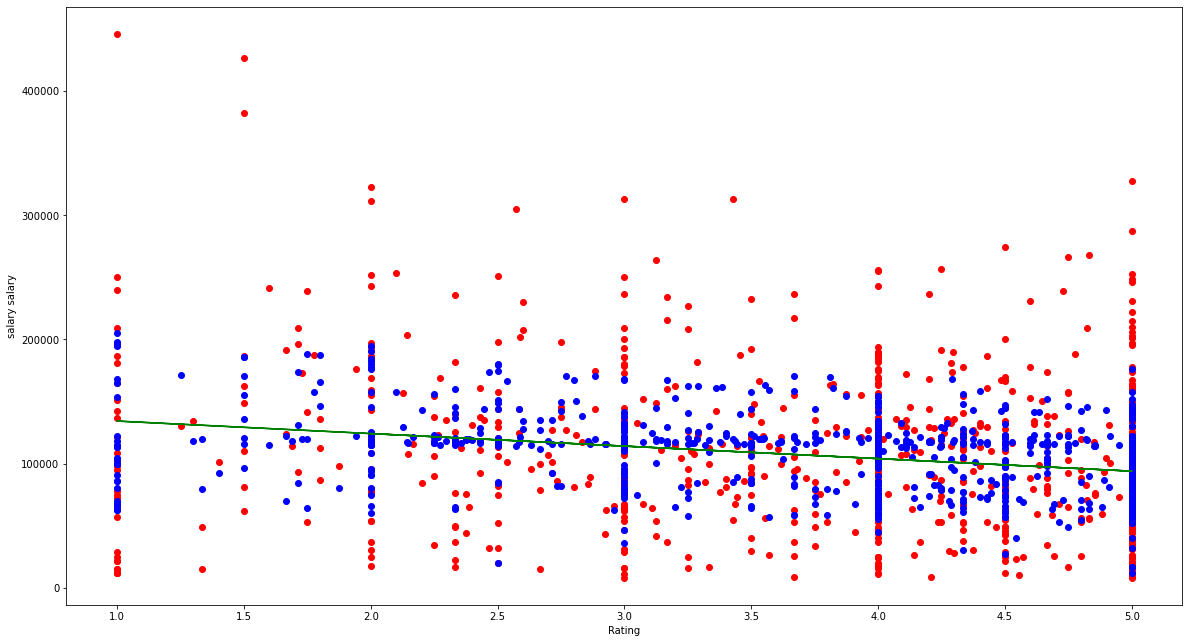

In [66]:

plt.figure(figsize=figsize)
plt.scatter(matched_salaries['avg_rating'], matched_salaries['salary'], color="red")
plt.scatter(matched_salaries['avg_rating'], matched_salaries['predicted_salary'], color="blue")
plt.xlabel('Rating')
plt.ylabel('salary salary')

x = prof_salary['avg_rating']
y = prof_salary['salary']

m,b = np.polyfit(x,y, 1)
plt.plot(x, m * x + b, color = "green")

plt.show()

### Hypothesis 2

Knowing the salary and average rating, and department for which each student submitted a review, we can predict what their expected grade shoule be.

In [29]:
def get_salary(x): 
    return matched_salaries.loc[x.prof_df_id]["salary"]
def get_department(x):
    return matched_salaries.loc[x.prof_df_id]["department"]
    
def map_grades(g): 
    if(pd.isnull(g)):
        return np.nan
    
    d = {'A': 90, "B": 80, "C": 70, "D": 60, "F": 50}
    match = re.search('[a-z|A-Z]', g, re.IGNORECASE)
    if(match == None):
        return np.nan
    val = d.get(match.group(0))
    return val if val != None else np.nan

# reviews_df['course_num'] = reviews_df.apply(lambda x: convert_to_num_rep(x.course), axis=1)
reviews_df['grade_num'] = reviews_df.apply(lambda x: map_grades(x.expected_grade), axis=1)
reviews_df['department'] = reviews_df.apply(lambda x: get_department(x), axis=1)
reviews_df['salary'] = reviews_df.apply(lambda x: get_salary(x), axis=1)
reviews_df.head()

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",0,NaN,BSOS,322501.74
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1,80.0,BSOS,75054.05
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1,90.0,BSOS,75054.05
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4,90.0,ARHU,37087.20
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4,90.0,ARHU,37087.20


In [30]:
missing_grades = reviews_df[pd.isnull(reviews_df["grade_num"])]
missing_grades

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",0,NaN,BSOS,322501.74
7,bhatele,5,NaN,NaN,Awesome professor!,9,NaN,CMNS,174021.38
12,jawahery,4,NaN,PHYS405,Phys 405 is difficult. It just is. Now that we...,12,NaN,CMNS,255121.04
20,hassam,5,NaN,PHYS121,Class is strait forward. Attend lecture and pr...,19,NaN,CMNS,129624.72
22,hassam,4,NaN,PHYS601,Prof. Hassam lays a lot of stress on students ...,19,NaN,CMNS,129624.72
...,...,...,...,...,...,...,...,...,...
5296,vishkin,2,NaN,ENEE446,Lectures were dry and very text dense - think ...,2178,NaN,AGNR,154039.62
5299,vishkin,1,NaN,ENEE641,His homework is straight out of the posted sol...,2178,NaN,AGNR,154039.62
5302,vishkin,1,NaN,NaN,If you are forced on gunpoint to take his cour...,2178,NaN,AGNR,154039.62
5306,hacquard,2,NaN,HONR218L,I did not enjoy this class. I expected it to ...,2179,NaN,CMNS,83422.01


In [31]:
non_missing_grades = reviews_df.dropna()
non_missing_grades

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...,1,80.0,BSOS,75054.05
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...,1,90.0,BSOS,75054.05
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...,4,90.0,ARHU,37087.20
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...,4,90.0,ARHU,37087.20
5,swanlek,5,A+,COMM107,"Professor Swanlek, if you're reading this, YOU...",4,90.0,ARHU,37087.20
...,...,...,...,...,...,...,...,...,...
5295,slocum,5,A+,HONR238C,"Pretty interesting class, get to listen to gue...",2174,90.0,SPHL,104235.12
5297,vishkin,5,B,ENEE446,"ENEE446 is a very insightful course, which in ...",2178,80.0,AGNR,154039.62
5303,hacquard,3,A,HONR218L,Hacquard gave a capable and comprehensive surv...,2179,90.0,CMNS,83422.01
5304,hacquard,4,A,HONR218L,I wasn't going to review this until I saw the ...,2179,90.0,CMNS,83422.01


In [67]:
[train_sample,  test_sample] = train_test_split(non_missing_grades)

In [45]:
def get_dummies(df):
    dept_features = pd.get_dummies(df['department'], drop_first = True, prefix = 'dept')
    std_features = df[['rating', 'grade_num', 'salary']]

    comb_features = pd.concat([std_features, dept_features], axis = 1)

    for i in filter(lambda i : i!= 'AGNR', non_missing_grades['department'].unique()):
        if i in comb_features.index:
            comb_features['grade_num*' + i] = comb_features['dept_' + i]*comb_features['grade_num']
            comb_features['rating*' + i] = comb_features['dept_' + i]*comb_features['rating']
        else:
            comb_features['grade_num*' + i] = 0
            comb_features['rating*' + i] = 0
    return comb_features

In [46]:
training_features = get_dummies(train_sample)

In [76]:
X2 = training_features.drop('grade_num', axis = 1)
y2 = training_features['grade_num']
reg2 = LinearRegression()
reg2.fit(X2,y2)

LinearRegression()

In [53]:
predictions = []
testing_fetures = get_dummies(test_sample)
X2 = testing_fetures.drop('grade_num', axis = 1)
y2 = training_features['grade_num']

for i, row in X2.iterrows():
    predictions.append(round(reg2.predict([X2.loc[i]])[0],2))
        
testing_fetures['predicted_grade'] = predictions
testing_fetures.head()

,rating,grade_num,salary,dept_ARCH,dept_ARHU,dept_BMGT,dept_BSOS,dept_CMNS,dept_EDUC,dept_ENGR,...,rating*UGST,grade_num*PLCY,rating*PLCY,grade_num*ARCH,rating*ARCH,grade_num*EXST,rating*EXST,grade_num*VPR,rating*VPR,predicted_grade
1590,4,80.0,114437.95,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,86.49
2296,5,90.0,100841.10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,88.31
396,4,90.0,92717.08,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,86.58
4839,4,90.0,231337.76,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,85.76
2760,2,90.0,25090.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,82.79


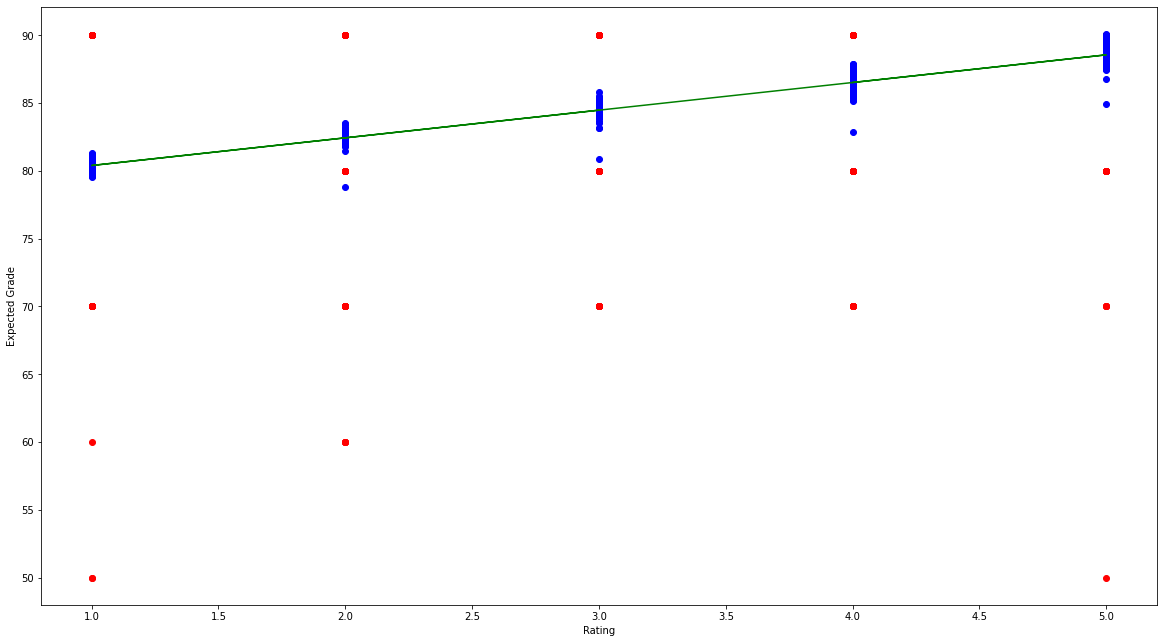

In [65]:

plt.figure(figsize=figsize)
plt.scatter(testing_fetures['rating'], testing_fetures['grade_num'], color="red")
plt.scatter(testing_fetures['rating'], testing_fetures['predicted_grade'], color="blue")
plt.xlabel('Rating')
plt.ylabel('Expected Grade')

x = testing_fetures['rating']
y = testing_fetures['predicted_grade']

m,b = np.polyfit(x,y, 1)
plt.plot(x, m * x + b, color = "green")

plt.show()

In [74]:
predictions = []
missing_features = get_dummies(reviews_df)
X2 = missing_features.drop('grade_num', axis = 1)
y2 = missing_features['grade_num']

for i, row in X2.iterrows():
    predictions.append(round(reg2.predict([X2.loc[i]])[0],2))
        
reviews_df['predicted_grade'] = predictions

In [75]:
reviews_df[pd.isnull(reviews_df["grade_num"])]

,slug,rating,expected_grade,course,review,prof_df_id,grade_num,department,salary,predicted_grade
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",0,NaN,BSOS,322501.74,82.11
7,bhatele,5,NaN,NaN,Awesome professor!,9,NaN,CMNS,174021.38,88.02
12,jawahery,4,NaN,PHYS405,Phys 405 is difficult. It just is. Now that we...,12,NaN,CMNS,255121.04,85.66
20,hassam,5,NaN,PHYS121,Class is strait forward. Attend lecture and pr...,19,NaN,CMNS,129624.72,88.19
22,hassam,4,NaN,PHYS601,Prof. Hassam lays a lot of stress on students ...,19,NaN,CMNS,129624.72,86.17
...,...,...,...,...,...,...,...,...,...,...
5296,vishkin,2,NaN,ENEE446,Lectures were dry and very text dense - think ...,2178,NaN,AGNR,154039.62,82.48
5299,vishkin,1,NaN,ENEE641,His homework is straight out of the posted sol...,2178,NaN,AGNR,154039.62,80.45
5302,vishkin,1,NaN,NaN,If you are forced on gunpoint to take his cour...,2178,NaN,AGNR,154039.62,80.45
5306,hacquard,2,NaN,HONR218L,I did not enjoy this class. I expected it to ...,2179,NaN,CMNS,83422.01,82.30


## Communication of insights attained